In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
class NonStationaryPricingEnvironment:
    def __init__(self, conversion_probabilities, cost, interval_length, seed=None):
        #np.random.seed(seed)
        self.conversion_probabilities = conversion_probabilities
        self.cost = cost
        self.interval_length = interval_length
        self.t = 0
        self.current_interval = 0

    def round(self, price_t, n_t):
        demand_t = np.random.binomial(n_t, self.conversion_probabilities[self.current_interval](price_t))
        reward_t = demand_t * (price_t - self.cost)
        self.t += 1
        if self.t % self.interval_length == 0:
            self.current_interval += 1
        return demand_t, reward_t

In [3]:
# Fix randomization
SEED = 1234
np.random.seed(SEED)

# Global parameters
SLOPE_MIN = 30
SLOPE_MAX = 50
PRICE_MIN = 10
PRICE_MAX = 30

# Parameters
T = 10000
n_customers = 100
cost = 10
interval_length = 2500
n_intervals = math.ceil(T / interval_length)

# Non-stationary conversion probabilities
conversion_probability = lambda price, slope: 1 - price / slope
slopes = [int(np.random.uniform(SLOPE_MIN, SLOPE_MAX)) for _ in range(n_intervals)]
conversion_probabilities = [lambda price: conversion_probability(price, slope) for slope in slopes]

# Action space
K = 100
prices = np.linspace(PRICE_MIN, PRICE_MAX, K)

# Demand curves
demand_curves = [n_customers * conversion_probability(prices, slope) for slope in slopes]

# Profit curves
profit_curves = [n_customers * (prices - cost) * conversion_probability(prices, slope) for slope in slopes]

# Best prices
best_prices_indices = [np.argmax(profit_curve) for profit_curve in profit_curves]
best_prices = [prices[i] for i in best_prices_indices]

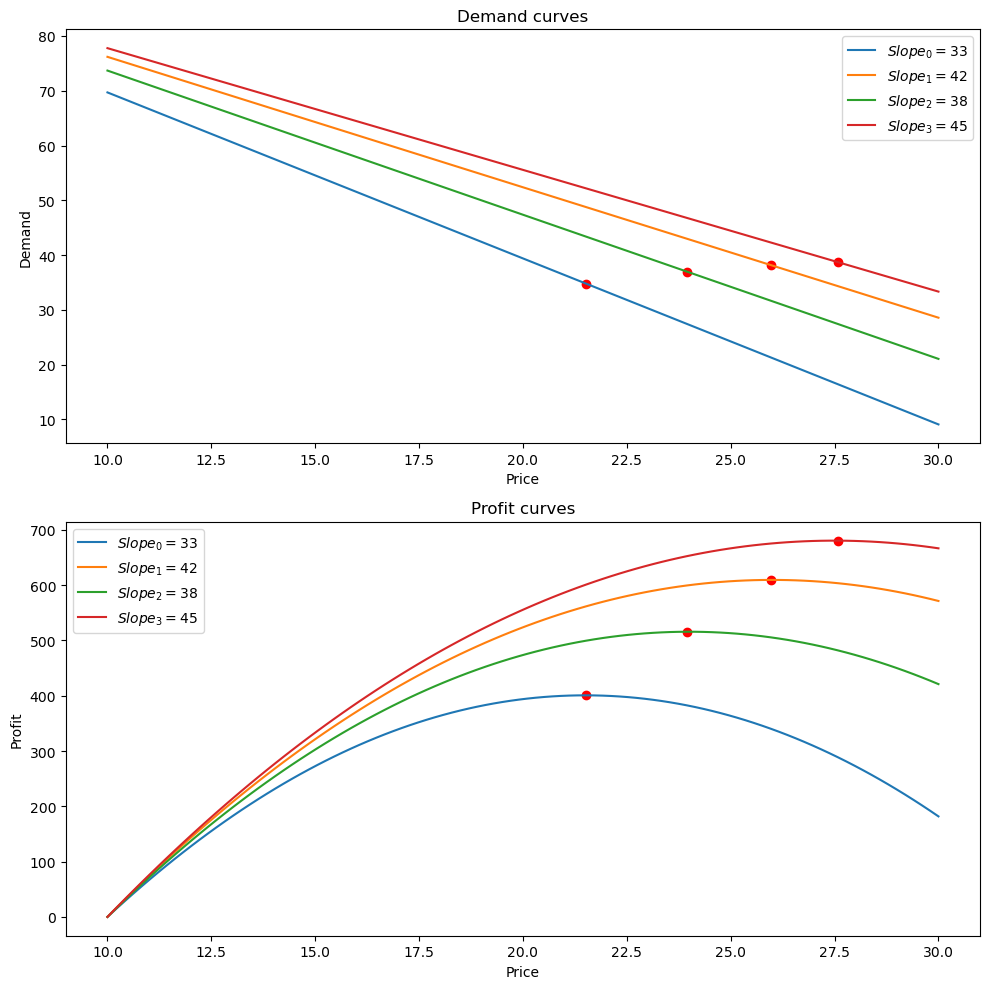

In [4]:
# Plot the demand curves together in one subplot, and the profit curves in another
# Also plot the best prices in both subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i in range(n_intervals):
    axs[0].plot(prices, demand_curves[i], label=f'$Slope_{i} = {slopes[i]}$')
    axs[0].scatter(best_prices[i], demand_curves[i][best_prices_indices[i]], color='red')
    axs[1].plot(prices, profit_curves[i], label=f'$Slope_{i} = {slopes[i]}$')
    axs[1].scatter(best_prices[i], profit_curves[i][best_prices_indices[i]], color='red')
axs[0].set_title('Demand curves')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Demand')
axs[0].legend()
axs[1].set_title('Profit curves')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Profit')
axs[1].legend()
plt.tight_layout()
plt.show()

In [18]:
conversion_probabilities[0](18.080808) * 100

59.82042666666667

In [5]:
for i in range(n_intervals):
    print(f'Best price for slope {slopes[i]}: {best_prices[i]} - Price index: {best_prices_indices[i]}')

Best price for slope 33: 21.515151515151516 - Price index: 57
Best price for slope 42: 25.95959595959596 - Price index: 79
Best price for slope 38: 23.939393939393938 - Price index: 69
Best price for slope 45: 27.575757575757574 - Price index: 87


In [6]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.action_t = None
        self.average_rewards = np.zeros(K)
        self.n_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.action_t = self.t
        else:
            ucb_values = self.average_rewards + self.range * np.sqrt(2 * np.log(self.t) / self.n_pulls)
            self.action_t = np.argmax(ucb_values)
        return self.action_t
    
    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        self.average_rewards[self.action_t] += (reward_t - self.average_rewards[self.action_t]) / self.n_pulls[self.action_t]
        self.t += 1

In [7]:
# Let's compute the clairvoyant rewards in expectation
# Best policy in hindsight
reward_function = lambda price, n_sales: n_sales * (price - cost)
maximum_profit = reward_function(prices.max(), n_customers)

# Let's compute the clairvoyant rewards in expectation -> best policy in hindsight
best_rewards = np.array([reward_function(prices[best_price_index], n_customers) for best_price_index in best_prices_indices])
best_rewards

array([1151.51515152, 1595.95959596, 1393.93939394, 1757.57575758])

In [8]:
best_cumulative_reward = sum(best_rewards)
best_cumulative_reward

5898.989898989899

In [9]:
expected_clairvoyant_rewards = np.array([])
for i in range(n_intervals):
    profit_curve = profit_curves[i]
    best_price_index = best_prices_indices[i]
    partial_expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], interval_length)
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, partial_expected_clairvoyant_rewards)

In [10]:
expected_clairvoyant_rewards[4995:5005]

array([609.51992265, 609.51992265, 609.51992265, 609.51992265,
       609.51992265, 515.77980765, 515.77980765, 515.77980765,
       515.77980765, 515.77980765])

/tmp/ipykernel_155851/3262565347.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(row, index=[0])])


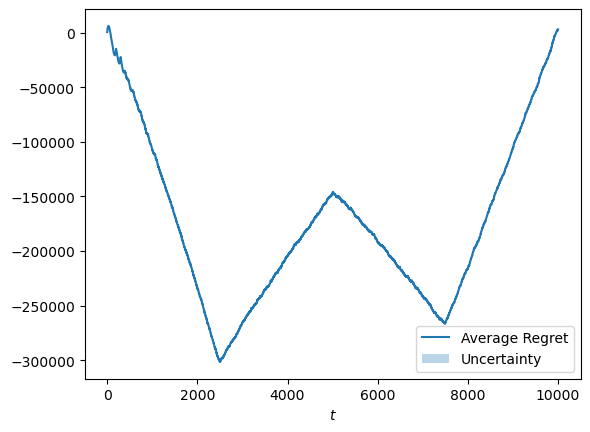

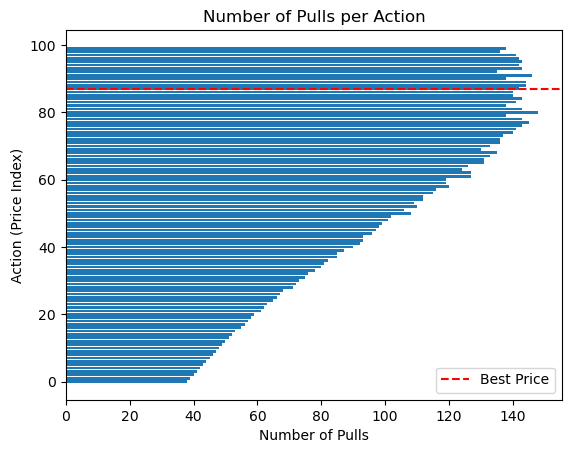

In [11]:
# Let's compute the clairvoyant rewards in expectation
# Best policy in hindsight
reward_function = lambda price, n_sales: n_sales * (price - cost)
maximum_profit = reward_function(prices.max(), n_customers)

# Let's compute the clairvoyant rewards in expectation -> best policy in hindsight
best_rewards = np.array([reward_function(prices[best_price_index], n_customers) for best_price_index in best_prices_indices])
best_cumulative_reward = sum(best_rewards)
expected_clairvoyant_rewards = np.array([])
for i in range(n_intervals):
    profit_curve = profit_curves[i]
    best_price_index = best_prices_indices[i]
    partial_expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], interval_length)
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, partial_expected_clairvoyant_rewards)

n_trials = 1

regret_per_trial = []

df = pd.DataFrame(columns=['Trial', 't', 'Price Index', 'Price', 'Demand', 'Reward', 'Expected Reward', 'Regret', 'Best Price Index'])

for seed in range(n_trials):
    #np.random.seed(seed)

    env = NonStationaryPricingEnvironment(conversion_probabilities, cost, interval_length, seed=seed)
    agent = UCB1Agent(K, T, range=maximum_profit)

    agent_rewards = np.array([])

    for t in range(T):
        price_index_t = agent.pull_arm()
        price_t = prices[price_index_t]
        demand_t, reward_t = env.round(price_t, n_customers)
        agent.update(reward_t)

        # Logging
        row = {
            'Trial': seed,
            't': t,
            'Price Index': price_index_t,
            'Price': price_t,
            'Demand': demand_t,
            'Reward': reward_t,
            'Expected Reward': expected_clairvoyant_rewards[t],
            'Regret': expected_clairvoyant_rewards[t] - reward_t,
            'Best Price Index': best_prices_indices[t // interval_length]
        }
        df = pd.concat([df, pd.DataFrame(row, index=[0])])

        agent_rewards = np.append(agent_rewards, reward_t)
    
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)
regret_std_normalized = regret_std / np.sqrt(n_trials)


# Plotting
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_std_normalized,
                 average_regret + regret_std_normalized,
                 alpha=0.3,
                 label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), agent.n_pulls)
plt.axhline(y=best_price_index, color='red', linestyle='--', label='Best Price')
plt.xlabel('Number of Pulls')
plt.ylabel('Action (Price Index)')
plt.legend()
plt.title('Number of Pulls per Action')
plt.show()

In [12]:
agent_rewards

array([  0.        ,  16.16161616,  31.91919192, ..., 203.63636364,
       640.        , 504.24242424])

In [15]:
62 * (18.08 - 10)

500.9599999999999

In [13]:
# Visualize rows 20 to 40 of the df
df.iloc[40:60]

,Trial,t,Price Index,Price,Demand,Reward,Expected Reward,Regret,Best Price Index
0,0,40,40,18.080808,62,501.010101,400.75688,-100.253221,57
0,0,41,41,18.282828,65,538.383838,400.75688,-137.626958,57
0,0,42,42,18.484848,64,543.030303,400.75688,-142.273423,57
0,0,43,43,18.686869,53,460.404040,400.75688,-59.647160,57
0,0,44,44,18.888889,62,551.111111,400.75688,-150.354231,57
0,0,45,45,19.090909,64,581.818182,400.75688,-181.061302,57
0,0,46,46,19.292929,52,483.232323,400.75688,-82.475443,57
0,0,47,47,19.494949,52,493.737374,400.75688,-92.980494,57
0,0,48,48,19.696970,52,504.242424,400.75688,-103.485544,57
0,0,49,49,19.898990,55,544.444444,400.75688,-143.687564,57


In [1]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W
        self.range = range
        self.action_t = None
        self.cache = np.repeat(np.nan, repeats=K * W).reshape(W, K)
        self.n_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.action_t = self.t
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            average_last_w = np.nanmean(self.cache, axis=0)
            ucbs = average_last_w + self.range * np.sqrt(2 * np.log(self.W) / n_pulls_last_w)
            self.action_t = np.argmax(ucbs)
        return self.action_t

    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.action_t] = reward_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

In [2]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99, range=1):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha = alpha
        self.range = range
        self.action_t = None
        self.reset_times = np.zeros(K)
        self.n_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0
    
    def pull_arm(self):
        if (self.counters > 0).any():
            for action in np.arange(self.K):
                if self.counters[action] > 0:
                    self.counters[action] -= 1
                    self.action_t = action
                    break
        else:
            if np.random.random() <= 1 - self.alpha:
                ucbs = self.average_rewards + self.range * np.sqrt(np.log(self.n_t) / self.n_pulls)
                self.action_t = np.argmax(ucbs)
            else:
                self.action_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.action_t
    
    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        self.all_rewards[self.action_t].append(reward_t)
        if self.counters[self.action_t] == 0:
            if self.change_detection():
                self.n_resets[self.action_t] += 1
                self.n_pulls[self.action_t] = 0
                self.average_rewards[self.action_t] = 0
                self.counters[self.action_t] = self.M
                self.all_rewards[self.action_t] = []
                self.reset_times[self.action_t] = self.t
            else:
                self.average_rewards[self.action_t] += (reward_t - self.average_rewards[self.action_t]) / self.n_pulls[self.action_t]
        self.n_t = sum(self.n_pulls)
        self.t += 1
    
    def change_detection(self):
        """
        CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm had a change in its mean reward.
        """
        u_0 = np.mean(self.all_rewards[self.action_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.action_t][self.M:]) - u_0, u_0 - np.array(self.all_rewards[self.action_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gm, gm]) >= self.h:
                return 1
        return 0